## Unsupervised Capstone Project

## Ten articles with 10 different authors have been selected for this project. The articles are obtained from free Gutenberg Project and they are all Christmas-related.

## Bag of Word will be used to extract features from this dataset. Two methods will be used to analyze the dataset. The unsupervised clustering - K-Menas Clustering, and supervised classification - Random Forest and Logistic Regression. The consistency of clusters producded by k-means clustering will be examined. The accuracy of predicting the authors from these two methods will be compared.

In [1]:
import timeit
start=timeit.default_timer()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import spacy
nlp = spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Load files

In [6]:
filename=['brady.txt','butler.txt','cutting.txt','dawson.txt','dyke.txt',
          'hughes.txt','mitchell.txt','richmond.txt','rinehart.txt','stretton.txt']

In [7]:
def load_text(filename):
    file=open(filename,'r')
    text=file.read()
    file.close
    return text

## Data Cleaning

In [8]:
def clean_text(text):
    text=text.lower()
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in text:
       if char not in punctuations:
           no_punct = no_punct + char
    
    no_punct=no_punct.replace("ï»¿"," ")
    no_punct=no_punct.replace("\n"," ")
    
    return no_punct

In [9]:
def sep_text(text):
    text=text.split()
    
    k=100 # Number of sentences
    size=int(len(text)/k)
    para=[None]*k
    j=0
    
    for i in range(0,k):
        para[i]=text[j:j+size]
        para[i]=' '.join(para[i])
        j=j+size
    
    return para

## 1. Unsupervised Clustering : K-Means Clustering

In [10]:
n_max=600

## Bag of Words

In [11]:
vectorizer=CountVectorizer(stop_words="english", 
                           analyzer='word', 
                           ngram_range=(1, 4), 
                           max_df=1.0, 
                           min_df=1, 
                           max_features=n_max)

In [12]:
df = pd.DataFrame()
for i in range(len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    text=sep_text(text)
    
    X = vectorizer.fit_transform(text)
    X_np=X.todense()
    X_df=pd.DataFrame(X_np)
    
    #author=filename[i].replace('.txt','')
    #X_df['author']=author   
    X_df['author']=i
    
    df=df.append(X_df)

In [13]:
df.shape

(1000, 601)

In [14]:
x=df.drop(['author'],axis=1)
y=df['author']

## Separate the dataset to four (4) evenly sized sub-set.

In [15]:
x_half1, x_half2, y_half1, y_half2 = train_test_split(x, 
                                                      y,
                                                      test_size=0.5,
                                                      random_state=0)

In [16]:
x1, x2, y1, y2 = train_test_split(x_half1, 
                                  y_half1,
                                  test_size=0.5,
                                  random_state=0)

In [17]:
x3, x4, y3, y4 = train_test_split(x_half2, 
                                  y_half2,
                                  test_size=0.5,
                                  random_state=0)

In [18]:
km = KMeans(n_clusters=10, init='k-means++', n_init=3, max_iter=100)

## 1.1 Clustering Consistency

## 1.1.1 Clusters Plot

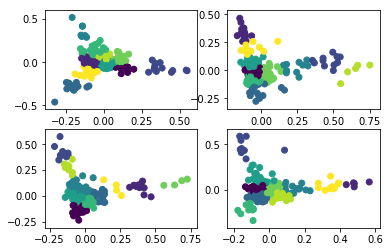

In [19]:
f,axarr=plt.subplots(2,2)
for x,i,j in [[x1,0,0],[x2,0,1],[x3,1,0],[x4,1,1]]:
    x_norm=normalize(x)
    x_pca=PCA(2).fit_transform(x_norm)
    y_pred=km.fit_predict(x_pca)
    axarr[i,j].scatter(x_pca[:,0],x_pca[:,1],c=y_pred)  

## From the four (4) plots above, we can conclude that the k-means does not produce consistent clustering with 10 clusters in this dataset.

## 1.1.2 Adjusted Rand Index

In [20]:
for x,y in [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]:
    x_norm=normalize(x)
    y_pred=km.fit_predict(x_norm)
    score=metrics.adjusted_rand_score(y, y_pred)
    print(score)

0.1096368163060274
0.26123299632982644
0.20620997725582244
0.1342568918070736


## The adjusted rand index from the four (4) samples indicate that the k-means clustering solution is close to random and the clusters produced is not very consistent.

## 1.1.3 Silhouette Coefficient

In [21]:
for x in [x1, x2, x3, x4]:
    x_norm=normalize(x)
    model = km.fit(x_norm)
    labels = model.labels_
    print(metrics.silhouette_score(x_norm, labels, metric='euclidean'))

0.0071715206167952735
0.016051786834903686
0.00982804935105153
0.00639551315685169


## The Silhouette Coefficient from the four (4) samples indicate that datapoints are closer to other datapoints in the same cluster than are to datapoints in the other clusters. The coefficient also indicate the clustering result is not very consistent.

## 1.2 Clustering Accuracy

## 1.2.1 Confusion Matrix

In [22]:
x_norm=normalize(x)
y_pred=km.fit_predict(x_norm)
print(pd.crosstab(y,y_pred))

col_0   0  1   2  3  4   5   6  7  8   9
author                                  
0       2  2   3  3  8   0   3  2  1   5
1       0  1   2  0  0   0  15  1  0   2
2       1  4   0  7  5   0   4  3  0   0
3       0  5  16  0  2   0   0  2  2   1
4       4  3   4  2  3   1   2  2  2   1
5       3  0   1  0  4   0   3  6  3   3
6       2  0   0  1  1   3   0  1  1  12
7       5  1   2  5  3   2   2  7  0   2
8       3  2   1  0  2   3   3  4  7   1
9       2  0   0  1  0  21   0  0  1   0


## 1.2.2 Accuracy Score

In [23]:
accuracy_score(y,y_pred)

0.08

## The accuracy of predicting the authors is very low with K-Means clustering technique.

## 2. Supervised Learning Classification

In [24]:
text_list=[]
for i in range(len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    text=sep_text(text)
    text_list=text_list+text

In [25]:
len(text_list)

1000

In [26]:
df.shape

(1000, 601)

## Bag of Words

In [27]:
vectorizer=CountVectorizer(stop_words="english", 
                           analyzer='word', 
                           ngram_range=(1, 4), 
                           max_df=1.0, 
                           min_df=1, 
                           max_features=n_max)

In [28]:
x = vectorizer.fit_transform(text_list)
x = x.toarray()
x.shape

(1000, 600)

In [29]:
y=df['author']

## Separate the dataset to 75% training set, and 25% testing set.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.25,
                                                    )

## Random Forest

In [31]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)
print('Training set score:', rfc.score(x_train, y_train))
print('\nTest set score:', rfc.score(x_test, y_test))

Training set score: 0.9933333333333333

Test set score: 0.72


## Logistic Regression

In [32]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print('Training set score:', lr.score(x_train, y_train))
print('\nTest set score:', lr.score(x_test, y_test))

Training set score: 1.0

Test set score: 0.848


### From the analysis above, we can conclude that the accuracy of predicting the author is way better with supervised learning classification technique than with unsupervised clustering technique.